In [4]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_fits.csv")
total = len(fits)

R2_threshold = 0.5
R2_filter = (fits.R2_1 > R2_threshold) & (fits.R2_2 > R2_threshold)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Good systems: 3748/15000 (24.99%)


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,V1,Pttv1,phase1,A2,B2,V2,Pttv2,phase2,R2_1,R2_2
0,2,0.001231,18.064109,0.002705,22.154587,-0.026507,2,7,13.628900,674.637818,...,0.708572,228.435939,1.760790,0.063622,-4.535777e-04,1.013388,227.953873,4.870417,0.947910,0.982851
1,7,0.042033,36.776952,0.001410,82.918436,0.054153,2,7,14.758149,62.870993,...,0.001233,139.604087,2.127186,-0.000879,2.826115e-06,0.014181,139.515198,5.423775,0.996469,0.997273
2,12,0.003260,74.828570,0.011135,61.329949,-0.028928,4,7,9.063341,3.087786,...,0.003447,78.648225,1.355034,-0.000578,1.126581e-06,0.001215,78.882690,4.549996,0.552683,0.634689
3,18,0.065756,82.884789,0.016307,3.628461,0.031656,3,7,10.832389,0.376612,...,0.004663,114.440403,0.454553,0.000002,8.247118e-09,0.000258,114.786614,3.578686,0.963919,0.974965
4,19,0.006460,64.978949,0.070559,62.393698,-0.093139,2,7,12.696060,344.344045,...,0.006449,68.240533,5.344276,0.010188,-6.383620e-06,0.021911,67.962702,2.680566,0.761729,0.600426


In [20]:
# Functions, returns in %
def err_gmean(calc, sol):
    gavg = gmean(calc/sol)
    return (gavg - 1) * 100

def err_med(calc, sol):
    gavg = np.median(calc/sol)
    return (gavg - 1) * 100

def err_gstd(calc, sol):
    logs = np.log(calc/sol)
    gstd = np.exp(logs.std(ddof=0))
    return gstd * 100

In [2]:
# Naive validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|█████████████████████████████████████████████████████████████████████████████| 3748/3748 [00:28<00:00, 133.51it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,B2,V2,Pttv2,phase2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,2,0.001231,18.064109,0.002705,22.154587,-0.026507,2,7,13.628900,674.637818,...,-4.535777e-04,1.013388,227.953873,4.870417,0.947910,0.982851,9701.072607,4006.955908,11903.082504,4646.814437
1,7,0.042033,36.776952,0.001410,82.918436,0.054153,2,7,14.758149,62.870993,...,2.826115e-06,0.014181,139.515198,5.423775,0.996469,0.997273,68.085633,6.854659,91.450850,13.817926
2,12,0.003260,74.828570,0.011135,61.329949,-0.028928,4,7,9.063341,3.087786,...,1.126581e-06,0.001215,78.882690,4.549996,0.552683,0.634689,3.402799,12.489443,6.421939,27.208986
3,18,0.065756,82.884789,0.016307,3.628461,0.031656,3,7,10.832389,0.376612,...,8.247118e-09,0.000258,114.786614,3.578686,0.963919,0.974965,0.408607,10.176591,0.299051,6.765545
4,19,0.006460,64.978949,0.070559,62.393698,-0.093139,2,7,12.696060,344.344045,...,-6.383620e-06,0.021911,67.962702,2.680566,0.761729,0.600426,317.326037,79.499741,1398.804668,189.397033


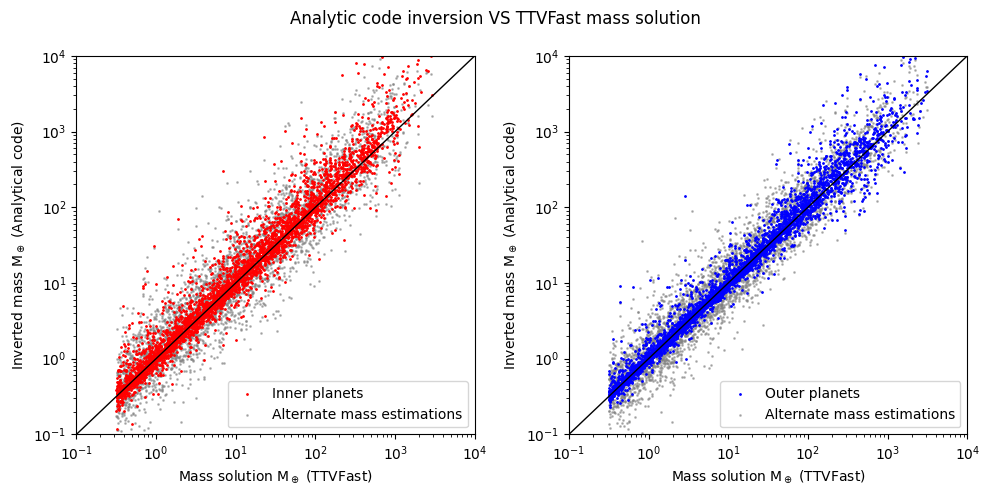

In [14]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4

# Inner planets
ax[0].scatter(compare['m1'], compare['m_calc_in'], s=s, color='red', label='Inner planets', zorder=0)
ax[0].scatter(compare['m1'], compare['m_bad_in'], s=s, color='grey', label='Alternate mass estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare['m2'], compare['m_calc_out'], s=s, color='blue', label='Outer planets', zorder=0)
ax[1].scatter(compare['m2'], compare['m_bad_out'], s=s, color='grey', label='Alternate mass estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.suptitle('Analytic code inversion VS TTVFast mass solution')
fig.tight_layout()
plt.show()

In [23]:
# Relative bias and average error
err1 = err_gmean(compare['m_calc_in'], compare['m1'])
err2 = err_gmean(compare['m_calc_out'], compare['m2'])
med1 = err_med(compare['m_calc_in'], compare['m1'])
med2 = err_med(compare['m_calc_out'], compare['m2'])
gstd1 = err_gstd(compare['m_calc_in'], compare['m1'])
gstd2 = err_gstd(compare['m_calc_out'], compare['m2'])

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.2f}%, {med1:.2f}%, {gstd1:.2f}%')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.2f}%, {med2:.2f}%, {gstd2:.2f}%')

Geometric mean error, median error, and geometric STD (Inner): 19.67%, 8.30%, 168.24%
Geometric mean error, median error, and geometric STD (Outer): 11.89%, 4.34%, 152.81%


In [13]:
# Naive nominal mass validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities() for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3748/3748 [00:39<00:00, 95.32it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,B2,V2,Pttv2,phase2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,2,0.001231,18.064109,0.002705,22.154587,-0.026507,2,7,13.628900,674.637818,...,-4.535777e-04,1.013388,227.953873,4.870417,0.947910,0.982851,9460.661729,3967.918143,12531.788719,4724.128909
1,7,0.042033,36.776952,0.001410,82.918436,0.054153,2,7,14.758149,62.870993,...,2.826115e-06,0.014181,139.515198,5.423775,0.996469,0.997273,321.834075,14.241818,195.214312,10.703636
2,12,0.003260,74.828570,0.011135,61.329949,-0.028928,4,7,9.063341,3.087786,...,1.126581e-06,0.001215,78.882690,4.549996,0.552683,0.634689,4.397756,16.690578,5.423652,22.858692
3,18,0.065756,82.884789,0.016307,3.628461,0.031656,3,7,10.832389,0.376612,...,8.247118e-09,0.000258,114.786614,3.578686,0.963919,0.974965,1.019222,31.238275,0.875352,24.352620
4,19,0.006460,64.978949,0.070559,62.393698,-0.093139,2,7,12.696060,344.344045,...,-6.383620e-06,0.021911,67.962702,2.680566,0.761729,0.600426,518.895753,99.208731,1273.123939,178.243351


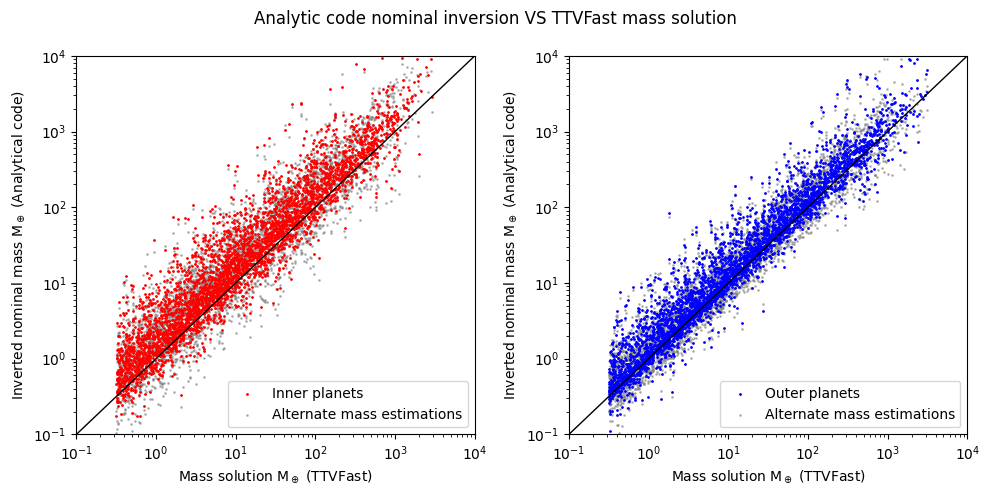

In [15]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4

# Inner planets
ax[0].scatter(compare_n['m1'], compare_n['m_calc_in'], s=s, color='red', label='Inner planets', zorder=0)
ax[0].scatter(compare_n['m1'], compare_n['m_bad_in'], s=s, color='grey', label='Alternate mass estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare_n['m2'], compare_n['m_calc_out'], s=s, color='blue', label='Outer planets', zorder=0)
ax[1].scatter(compare_n['m2'], compare_n['m_bad_out'], s=s, color='grey', label='Alternate mass estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.suptitle('Analytic code nominal inversion VS TTVFast mass solution')
fig.tight_layout()
plt.show()

In [24]:
# Relative bias and average error
err1 = err_gmean(compare_n['m_calc_in'], compare_n['m1'])
err2 = err_gmean(compare_n['m_calc_out'], compare_n['m2'])
med1 = err_med(compare_n['m_calc_in'], compare_n['m1'])
med2 = err_med(compare_n['m_calc_out'], compare_n['m2'])
gstd1 = err_gstd(compare_n['m_calc_in'], compare_n['m1'])
gstd2 = err_gstd(compare_n['m_calc_out'], compare_n['m2'])

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.2f}%, {med1:.2f}%, {gstd1:.2f}%')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.2f}%, {med2:.2f}%, {gstd2:.2f}%')

Geometric mean error, median error, and geometric STD (Inner): 77.52%, 57.26%, 205.84%
Geometric mean error, median error, and geometric STD (Outer): 40.59%, 23.54%, 178.94%
